# Create graphs

## Graph 1 - mAP as a function of the train-size for the complete experiment 

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10,10
import warnings
warnings.filterwarnings("ignore")

In [2]:
two_up = os.path.dirname(os.path.dirname(os.getcwd()))

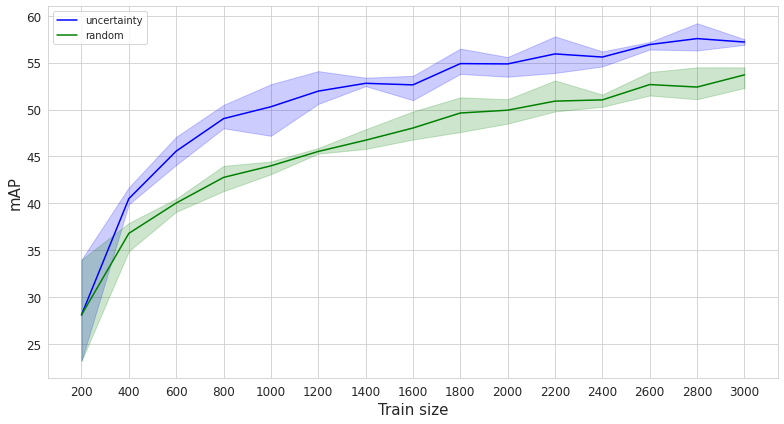

In [3]:
runs = ['run1', 'run2', 'run3']
sampling_methods = ['uncertainty', 'random']
colors = ["blue", "green"]
palette = ["b", "g"]
rootdir = os.path.join(two_up, 'results/exp2')

font_size = 15
digit_size = 12
annot_size = 11

dfs = []

for r in range(len(runs)):
    run = runs[r]
    for i in range(len(sampling_methods)):
        sampling_method = sampling_methods[i]
        csvfile = os.path.join(rootdir, run, sampling_method, sampling_method + '.csv')
        data = pd.read_csv(csvfile)
        df1 = data[['train_size', 'mAP']]
        df1['method'] = sampling_method
        dfs.append(df1)

df = pd.concat(dfs)
pool_size = df.iloc[1,0] - df.iloc[0,0]

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=df, x="train_size", y="mAP", hue="method", ci=95, markers=True, palette=palette)
plt.legend(loc='upper left')
plt.xlabel('Train size', fontsize=font_size)
plt.xticks(range(df['train_size'].min(), df['train_size'].max()+pool_size, pool_size), fontsize=digit_size)
plt.ylabel('mAP', fontsize=font_size)
plt.yticks(fontsize=digit_size)

line_values = df.groupby(['train_size', 'method'])['mAP'].mean()
last_value_random = line_values.loc[df['train_size'].max()]['random']
# line1 = ax.lines[1]
# line1.get_ydata()
# plt.hlines(last_value_random, df['train_size'].min(), df['train_size'].max(), colors='k', linestyles='dashed')      

plt.tight_layout()
plt.savefig(os.path.join(rootdir, "mAP_active_learning.png"))
plt.show()

## Graph 2 - mAP as a function of the train-size per individual run

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10,10
import warnings
warnings.filterwarnings("ignore")

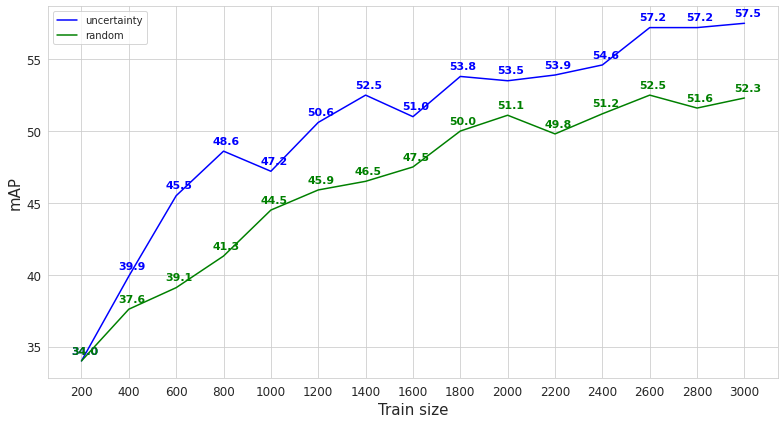

In [5]:
sampling_methods = ['uncertainty', 'random']
colors = ["blue", "green"]
palette = ["b", "g"]
rootdir = os.path.join(two_up, 'results/exp2/run1')
header = ['train size']

font_size = 15
digit_size = 12
annot_size = 11

dfs = []

for i in range(len(sampling_methods)):
    sampling_method = sampling_methods[i]
    header.append(sampling_method)
    csvfile = os.path.join(rootdir, sampling_method, sampling_method + '.csv')
    data = pd.read_csv(csvfile)
    if i == 0:
        df1 = data[['train_size', 'mAP']]
    else:
        df1 = data['mAP']
    dfs.append(df1)

df = pd.concat(dfs, axis=1)
df.columns = header
pool_size = df.iloc[1,0] - df.iloc[0,0]

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(x='train size', y='value', hue='variable', data=pd.melt(df, ['train size']), palette=palette)
plt.legend(loc='upper left')
plt.xlabel('Train size', fontsize=font_size)
plt.xticks(range(df['train size'].min(), df['train size'].max()+pool_size, pool_size), fontsize=digit_size)
plt.ylabel('mAP', fontsize=font_size)
plt.yticks(fontsize=digit_size)

## annotation
for j in range(len(sampling_methods)):
    sampling_method = sampling_methods[j]
    df2 = df[['train size', sampling_method]]
    for k in range(len(df2)):
        xval = df2.loc[k]['train size']
        yval = df2.loc[k][sampling_method]
        plt.annotate("{:.1f}".format(yval), (xval-45, yval+0.5), fontsize=annot_size, weight='bold', color=colors[j])

plt.tight_layout()
plt.savefig(os.path.join(rootdir, "mAP_active_learning.png"))
plt.show()

# Pooled class-instances

In [6]:
import random
import os
import numpy as np
import shutil
import cv2
from PIL import Image
import json
import math
import datetime
import time
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from shutil import copyfile
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10,10
import warnings
warnings.filterwarnings("ignore")

In [7]:
supported_cv2_formats = (".bmp", ".dib", ".jpeg", ".jpg", ".jpe", ".jp2", ".png", ".pbm", ".pgm", ".ppm", ".sr", ".ras", ".tiff", ".tif")


def check_direxcist(dir):
    if dir is not None:
        if not os.path.exists(dir):
            os.makedirs(dir)  # make new folder


def find_valid_images_and_annotations(rootdir):
    image_annotation_pairs = []

    for root, dirs, files in tqdm(list(os.walk(rootdir))):
        for name in files:
            if name.endswith((".json")):
                full_path = os.path.join(root, name)
                with open(full_path, 'r') as json_file:
                    try:
                        data = json.load(json_file)

                        ## labelme
                        if 'version' in data:
                            annot_format = 'labelme'
                            if 'shapes' in data:
                                if len(data['shapes']) > 0:
                                    imgname = data['imagePath']
                                    imgpath = os.path.join(root, imgname)

                                    if os.path.exists(imgpath):
                                        image_annotation_pairs.append([os.path.basename(root), imgpath, full_path, annot_format])

                    except:
                        continue

    return image_annotation_pairs


def process_labelme_json(jsonfile, classnames):
    group_ids = []

    with open(jsonfile, 'r') as json_file:
        data = json.load(json_file)
        for p in data['shapes']:
            group_ids.append(p['group_id'])

    only_group_ids = [x for x in group_ids if x is not None]
    unique_group_ids = list(set(only_group_ids))
    no_group_ids = sum(x is None for x in group_ids)
    total_masks = len(unique_group_ids) + no_group_ids

    all_unique_masks = np.zeros(total_masks, dtype = object)

    if len(unique_group_ids) > 0:
        unique_group_ids.sort()

        for k in range(len(unique_group_ids)):
            unique_group_id = unique_group_ids[k]
            all_unique_masks[k] = unique_group_id

        for h in range(no_group_ids):
            all_unique_masks[len(unique_group_ids) + h] = "None" + str(h+1)
    else:
        for h in range(no_group_ids):
            all_unique_masks[h] = "None" + str(h+1)    

    category_ids = []
    masks = []
    crowd_ids = []

    for i in range(total_masks):
        category_ids.append([])
        masks.append([])
        crowd_ids.append([])

    none_counter = 0 

    for p in data['shapes']:
        group_id = p['group_id']

        if group_id is None:
            none_counter = none_counter + 1
            fill_id = int(np.where(np.asarray(all_unique_masks) == (str(group_id) + str(none_counter)))[0][0])
        else:
            fill_id = int(np.where(np.asarray(all_unique_masks) == group_id)[0][0])

        classname = p['label']

        try:
            category_ids[fill_id] = classname
            run_further = True
        except:
            print("Cannot find the class name (please check the annotation files)")
            run_further = False

        if run_further:
            if p['shape_type'] == "circle":
                # https://github.com/wkentaro/labelme/issues/537
                bearing_angles = [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 
                180, 195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360]
                            
                orig_x1 = p['points'][0][0]
                orig_y1 = p['points'][0][1]

                orig_x2 = p['points'][1][0]
                orig_y2 = p['points'][1][1]

                cx = (orig_x2 - orig_x1)**2
                cy = (orig_y2 - orig_y1)**2
                radius = math.sqrt(cx + cy)

                circle_polygon = []
            
                for k in range(0, len(bearing_angles) - 1):
                    ad1 = math.radians(bearing_angles[k])
                    x1 = radius * math.cos(ad1)
                    y1 = radius * math.sin(ad1)
                    circle_polygon.append( (orig_x1 + x1, orig_y1 + y1) )

                    ad2 = math.radians(bearing_angles[k+1])
                    x2 = radius * math.cos(ad2)  
                    y2 = radius * math.sin(ad2)
                    circle_polygon.append( (orig_x1 + x2, orig_y1 + y2) )

                pts = np.asarray(circle_polygon).astype(np.float32)
                pts = pts.reshape((-1,1,2))
                points = np.asarray(pts).flatten().tolist()
                
            if p['shape_type'] == "rectangle":
                (x1, y1), (x2, y2) = p['points']
                x1, x2 = sorted([x1, x2])
                y1, y2 = sorted([y1, y2])
                points = [x1, y1, x2, y1, x2, y2, x1, y2]

            if p['shape_type'] == "polygon":
                points = p['points']
                pts = np.asarray(points).astype(np.float32).reshape(-1,1,2)   
                points = np.asarray(pts).flatten().tolist()

            masks[fill_id].append(points)

            ## labelme version 4.5.6 does not have a crowd_id, so fill it with zeros
            crowd_ids[fill_id] = 0
            status = "successful"
        else:
            status = "unsuccessful"

    return category_ids, masks, crowd_ids, status

## Graph 3 - Pooled class-instances as a function of the train-size (log-line) 

100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


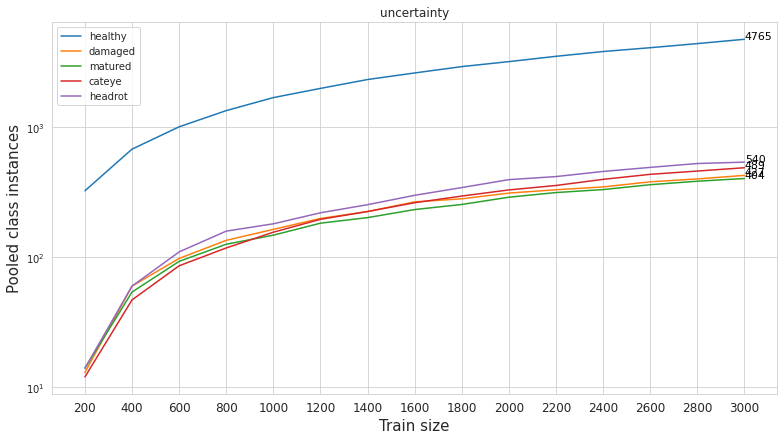

100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


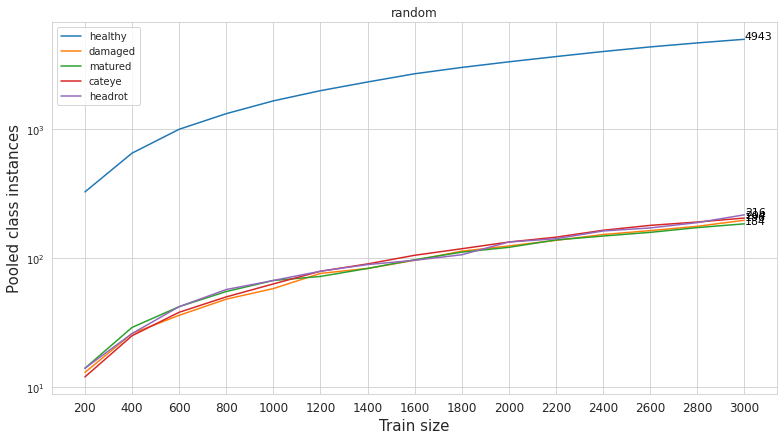

In [8]:
sampling_methods = ['uncertainty', 'random']
rootdir = os.path.join(two_up, 'results/exp2/run3')
imgdir = os.path.join(two_up, 'datasets/train')

classes = ['healthy', 'damaged', 'matured', 'cateye', 'headrot']
header = classes.copy()
header.insert(0, 'iteration')
header.insert(1, 'train size')

font_size = 15
digit_size = 12
annot_size = 11

for s in range(len(sampling_methods)):
    sampling_method = sampling_methods[s]
    pooldir = os.path.join(rootdir, sampling_method)
    data_combined = []

    if os.path.isdir(pooldir):
        all_files = os.listdir(pooldir)
        txtfiles = [x for x in all_files if x.endswith('.txt')]

        for t in tqdm(range(len(txtfiles))):
            txtfile = txtfiles[t]
            iter = int(txtfile.split("trainfiles_iteration")[1].split(".txt")[0])
            class_categories = []
            train_size = 0
            with open(os.path.join(pooldir, txtfile)) as f:
                for line in f:
                    if line != '\n':
                        train_size += 1
                    basename = os.path.splitext(line)[0]
                    annot_name = basename + ".json"
                    annot_file = os.path.join(imgdir, annot_name)

                    if os.path.exists(annot_file):
                        categories, masks, crowd_ids, status = process_labelme_json(annot_file, classes)

                        for c in range(len(categories)):
                            category = categories[c]
                            class_categories.append(category)

            ucc = list(Counter(class_categories).keys())
            vcc = list(Counter(class_categories).values())
            count_list = np.zeros(len(classes)).astype(np.int16)

            for b in range(len(classes)):
                _class = classes[b]
                idx = ucc.index(_class)
                count_list[b] = vcc[idx]

            data_to_merge = list(count_list)
            data_to_merge.insert(0, iter)
            data_to_merge.insert(1, train_size)
            data_combined.append(data_to_merge)

    df = pd.DataFrame(data=data_combined, columns=header)
    df.sort_values(by=['iteration'], ignore_index=True, inplace=True)
    pool_size = df['train size'][1] - df['train size'][0]

    sns.set_style("whitegrid")
    f, ax = plt.subplots(figsize=(11, 6))

    df1 = df.loc[:, df.columns != 'iteration']
    ax = sns.lineplot(x='train size', y='value', hue='variable', data=pd.melt(df1, ['train size']))
    plt.legend(loc='upper left')
    plt.xlabel('Train size', fontsize=font_size)
    plt.xticks(range(df['train size'][0], df['train size'].max()+pool_size, pool_size), fontsize=digit_size)
    plt.ylabel('Pooled class instances', fontsize=font_size)
    ax.set_yscale("log")

    for c in range(len(classes)):
        _class = classes[c]
        xval = df1.loc[len(df1)-1]['train size']
        yval = df1.loc[len(df1)-1][_class]
        plt.annotate("{:d}".format(yval), (xval+2, yval-1), fontsize=annot_size, color="black")

    plt.tight_layout()
    plt.title(sampling_method)
    write_name = "class_instances_{:s}_sampling.png".format(sampling_method)
    plt.savefig(os.path.join(rootdir, write_name))
    plt.show()

## Graph 4 - Pooled class-instances as a function of the train-size (stacked bar-chart) 

100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


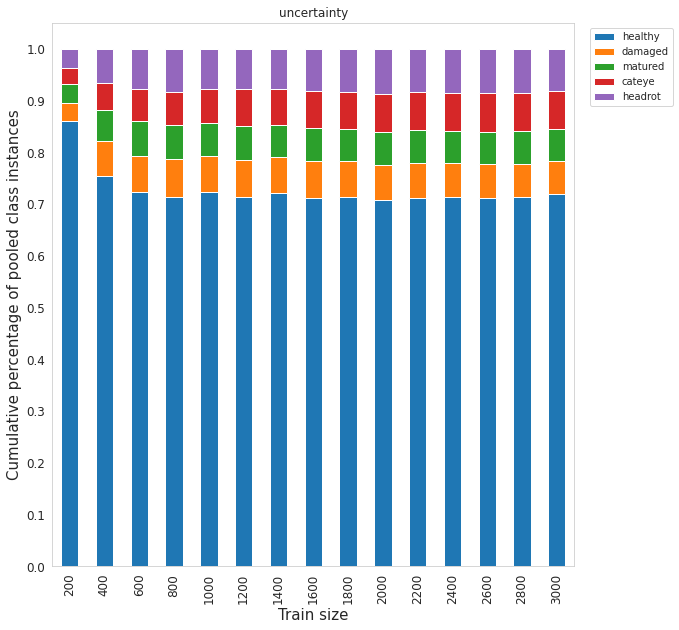

100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


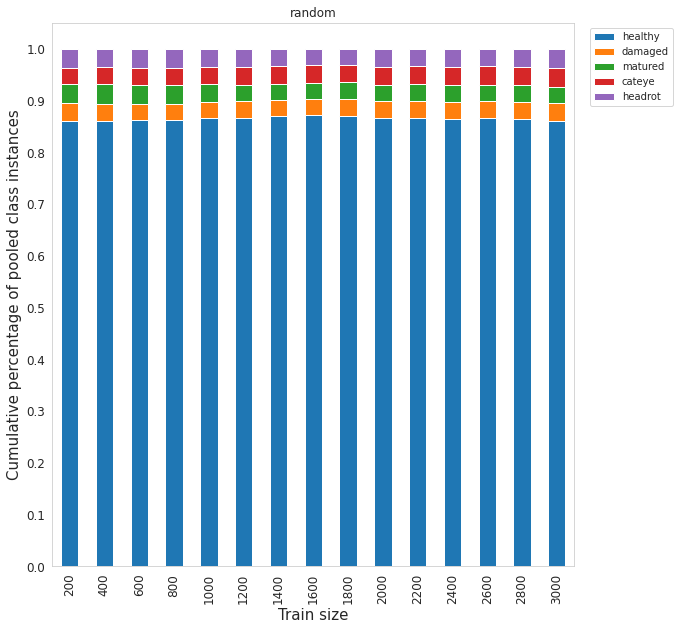

In [9]:
sampling_methods = ['uncertainty', 'random']
rootdir = os.path.join(two_up, 'results/exp2/run3')
imgdir = os.path.join(two_up, 'datasets/train')

classes = ['healthy', 'damaged', 'matured', 'cateye', 'headrot']
class_names = ['healthy_total', 'damaged_total', 'matured_total', 'cateye_total', 'headrot_total']
header = class_names.copy()
header.insert(0, 'iteration')
header.insert(1, 'train size')

font_size = 15
digit_size = 12
annot_size = 11

for s in range(len(sampling_methods)):
    sampling_method = sampling_methods[s]
    pooldir = os.path.join(rootdir, sampling_method)
    data_combined = []
    plt.rcParams["axes.grid"] = False

    if os.path.isdir(pooldir):
        all_files = os.listdir(pooldir)
        txtfiles = [x for x in all_files if x.endswith('.txt')]

        for t in tqdm(range(len(txtfiles))):
            txtfile = txtfiles[t]
            iter = int(txtfile.split("trainfiles_iteration")[1].split(".txt")[0])
            class_categories = []
            train_size = 0
            with open(os.path.join(pooldir, txtfile)) as f:
                for line in f:
                    if line != '\n':
                        train_size += 1
                    basename = os.path.splitext(line)[0]
                    annot_name = basename + ".json"
                    annot_file = os.path.join(imgdir, annot_name)

                    if os.path.exists(annot_file):
                        categories, masks, crowd_ids, status = process_labelme_json(annot_file, classes)

                        for c in range(len(categories)):
                            category = categories[c]
                            class_categories.append(category)

            ucc = list(Counter(class_categories).keys())
            vcc = list(Counter(class_categories).values())
            count_list = np.zeros(len(classes)).astype(np.int16)

            for b in range(len(classes)):
                _class = classes[b]
                idx = ucc.index(_class)
                count_list[b] = vcc[idx]

            data_to_merge = list(count_list)
            data_to_merge.insert(0, iter)
            data_to_merge.insert(1, train_size)
            data_combined.append(data_to_merge)

    df = pd.DataFrame(data=data_combined, columns=header)
    df.sort_values(by=['iteration'], ignore_index=True, inplace=True)
    pool_size = df['train size'][1] - df['train size'][0]

    cum_values = []
    total = df.copy()
    total['sum'] = df.loc[:, class_names[0]:class_names[-1]].sum(axis=1)
    total.drop(columns=class_names)

    for c in range(len(classes)):
        _class = classes[c]
        class_name = class_names[c]
        total[_class] = df.loc[:][class_name] / total['sum']

    df2 = total.loc[:, classes[0]:classes[-1]]
    ax = df2.plot.bar(stacked=True)

    plt.subplots_adjust(right=0.85)
    plt.title(sampling_method)
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
    plt.xlabel('Train size', fontsize=font_size)
    plt.xticks(range(0, df['iteration'].max()+1), range(df['train size'][0], df['train size'].max()+pool_size, pool_size), fontsize=digit_size)
    plt.ylabel('Cumulative percentage of pooled class instances', fontsize=font_size)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=digit_size)

    write_name = "class_instances_{:s}_sampling.png".format(sampling_method)
    plt.savefig(os.path.join(rootdir, write_name))
    plt.show()